In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


MASTER HYBRID DATASET LOADED (N=150)
Training Dataset (Archival): Records 0-104
Validation Dataset (Primary Survey): Records 105-149

Objective 1 Completed: PERI Index successfully engineered.

COMPARATIVE PROOF
               Metric  Model A (Baseline - Raw)  Model B (Proposed - PERI)
         Accuracy (%)                    86.667                     86.667
             F1-Score                     0.769                      0.769
              AUC-ROC                     0.732                      0.806
Prediction Confidence                     0.803                      0.926


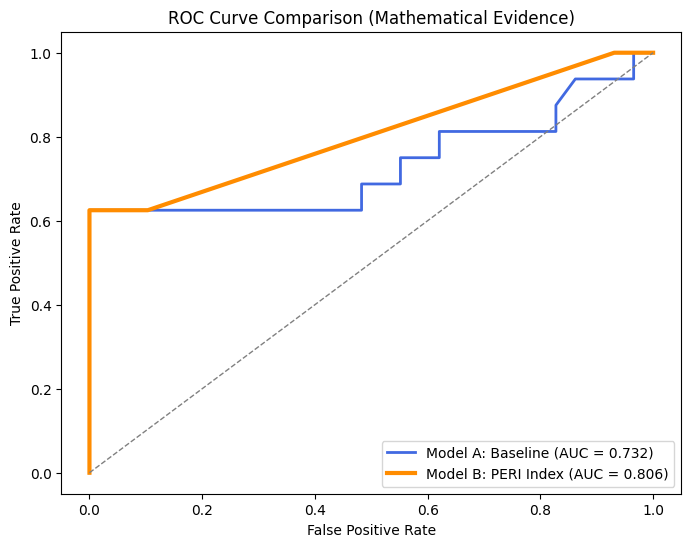

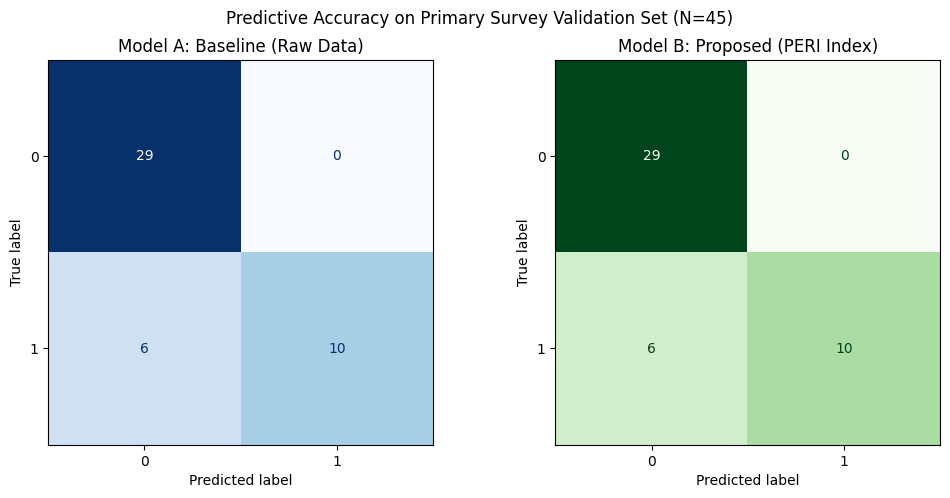

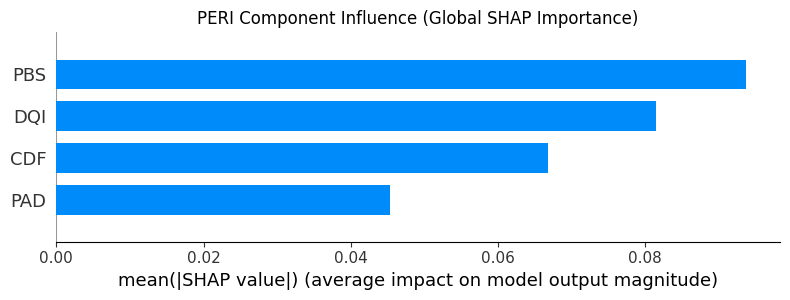

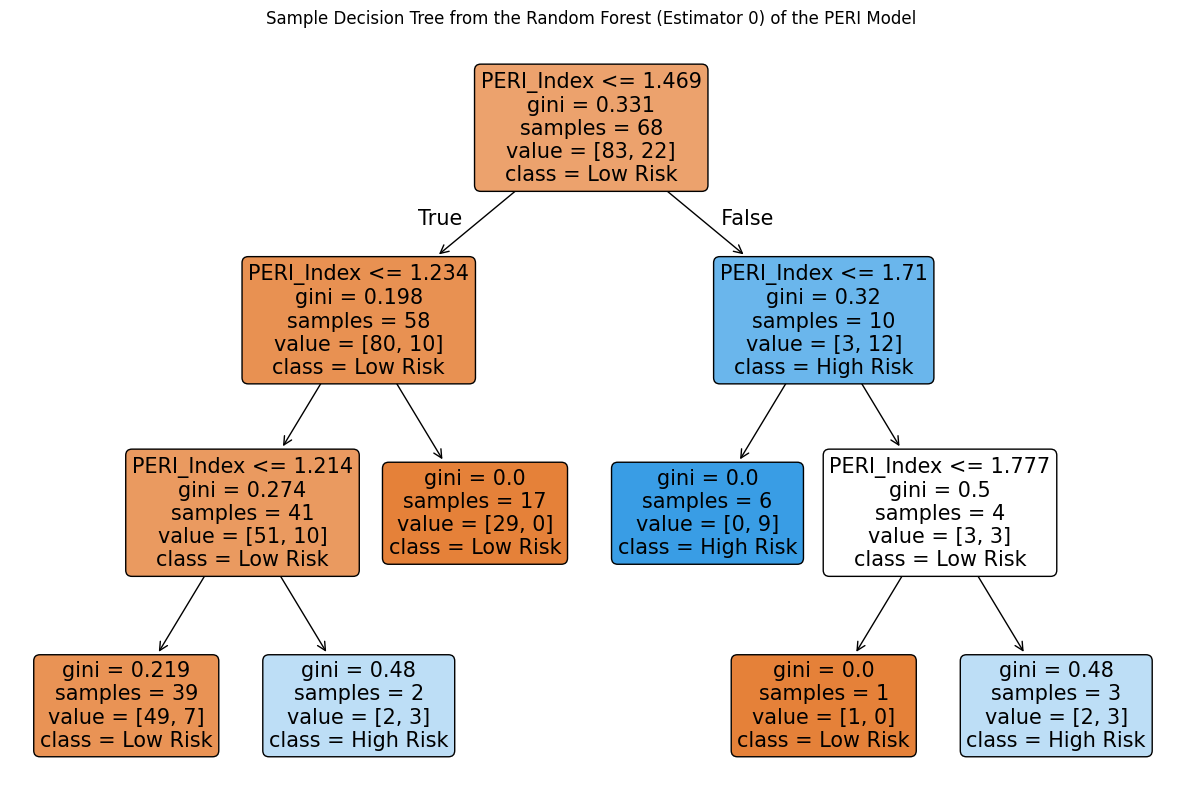

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.tree import plot_tree
import shap
import os


# 1. Loading the final hybrid dataset (N=150)
file_path = '/content/drive/MyDrive/MS THESIS/final_master_hybrid_n150.csv'

if not os.path.exists(file_path):
    file_path = '/content/drive/MyDrive/MS THESIS/final_master_hybrid_n150.csv'

try:
    df = pd.read_csv(file_path)
    print(f"MASTER HYBRID DATASET LOADED (N={len(df)})")
    print("Training Dataset (Archival): Records 0-104")
    print("Validation Dataset (Primary Survey): Records 105-149\n")
except Exception as e:
    print(f"Error: Could not load the dataset. {e}")
    import sys
    sys.exit()


# 2. Objective 1: Peri feature engineering
scaler = MinMaxScaler()

# PAD: Physical Activity Deficit (Dual-Logic Bridge)
df['Steps_Deficit'] = (7500 - df['Daily_Steps']).clip(lower=0) / 7500
train_mask = df.index < 105
val_mask = df.index >= 105
df.loc[train_mask, 'Act_Deficit'] = (30 - df.loc[train_mask, 'Activity_Value']).clip(lower=0) / 30
df.loc[val_mask, 'Act_Deficit'] = (4 - df.loc[val_mask, 'Activity_Value']).clip(lower=0) / 4
df['PAD_raw'] = (df['Steps_Deficit'] + df['Act_Deficit']) / 2

# CDF: Circadian Disruption
df['CDF_raw'] = abs(8.0 - df['Sleep_Duration']) + df['Quality_of_Sleep']

# PBS: Psychosocial Burden
df['PBS_raw'] = df['Stress_Level'] + (df['Heart_Rate'] - 70).clip(lower=0)

# DQI: Diet Quality Index derived from BMI classification
bmi_map = {'Normal': 0, 'Overweight': 1, 'Obese': 2}
df['DQI_raw'] = df['BMI_Category'].map(bmi_map).fillna(0)

# Normalization of PERI components
peri_cols = ['PAD_raw', 'CDF_raw', 'PBS_raw', 'DQI_raw']
df[['PAD', 'CDF', 'PBS', 'DQI']] = scaler.fit_transform(df[peri_cols])

# Aggregating final PERI index
df['PERI_Index'] = df['PAD'] + df['CDF'] + df['PBS'] + df['DQI']

print("Objective 1 Completed: PERI Index successfully engineered.")


# 3. Objective 2: Comparative Machine Learning modeling (Random Forest)
# Encoding categorical BMI variable for baseline model
le = LabelEncoder()
df['BMI_Encoded'] = le.fit_transform(df['BMI_Category'])

# Model A: Baseline using raw lifestyle variables
X_a = df[['Daily_Steps', 'Activity_Value', 'Sleep_Duration', 'Quality_of_Sleep', 'Stress_Level', 'Heart_Rate', 'BMI_Encoded']]
# Model B: Proposed PERI-based model
X_b = df[['PERI_Index']]
y = df['IBS_C_Risk']

# External validation split (Archival dataset for training (N=105) and Primary dataset for testing (N=45))
X_a_train, X_a_test = X_a.iloc[:105], X_a.iloc[105:]
X_b_train, X_b_test = X_b.iloc[:105], X_b.iloc[105:]
y_train, y_test = y.iloc[:105], y.iloc[105:]

# Random Forest model training
clf_a = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42).fit(X_a_train, y_train)
clf_b = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42).fit(X_b_train, y_train)

# Probabilities and predictions
y_prob_a = clf_a.predict_proba(X_a_test)[:, 1]
y_prob_b = clf_b.predict_proba(X_b_test)[:, 1]
y_pred_a = clf_a.predict(X_a_test)
y_pred_b = clf_b.predict(X_b_test)


# 4. Mathematical evidence (Comparative proof)
# Calculating Prediction Confidence: Average probability assigned to the correct class
correct_mask_a = (y_pred_a == y_test)
correct_mask_b = (y_pred_b == y_test)
conf_a = np.mean(np.abs(y_prob_a[correct_mask_a] - (1 - y_test[correct_mask_a])))
conf_b = np.mean(np.abs(y_prob_b[correct_mask_b] - (1 - y_test[correct_mask_b])))

print("\n" + "="*60)
print("COMPARATIVE PROOF")
print("="*60)

results = pd.DataFrame({
    'Metric': ['Accuracy (%)', 'F1-Score', 'AUC-ROC', 'Prediction Confidence'],
    'Model A (Baseline - Raw)': [
        accuracy_score(y_test, y_pred_a)*100,
        f1_score(y_test, y_pred_a),
        roc_auc_score(y_test, y_prob_a),
        conf_a
    ],
    'Model B (Proposed - PERI)': [
        accuracy_score(y_test, y_pred_b)*100,
        f1_score(y_test, y_pred_b),
        roc_auc_score(y_test, y_prob_b),
        conf_b
    ]
})
print(results.round(3).to_string(index=False))

# AUC-ROC curve visualization
fpr_a, tpr_a, _ = roc_curve(y_test, y_prob_a)
fpr_b, tpr_b, _ = roc_curve(y_test, y_prob_b)

plt.figure(figsize=(8, 6))
plt.plot(fpr_a, tpr_a, color='royalblue', lw=2, label=f'Model A: Baseline (AUC = {auc(fpr_a, tpr_a):.3f})')
plt.plot(fpr_b, tpr_b, color='darkorange', lw=3, label=f'Model B: PERI Index (AUC = {auc(fpr_b, tpr_b):.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison (Mathematical Evidence)')
plt.legend(loc="lower right")
plt.show()

# Confusion matrix comparison visualization
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_a, ax=ax[0], cmap='Blues', colorbar=False)
ax[0].set_title('Model A: Baseline (Raw Data)')
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_b, ax=ax[1], cmap='Greens', colorbar=False)
ax[1].set_title('Model B: Proposed (PERI Index)')
plt.suptitle('Predictive Accuracy on Primary Survey Validation Set (N=45)')
plt.show()


# 5. Objective 3: Model explainability using SHAP analysis
# Analyzing which PERI component drove the risk in the primary cohort
X_shap = df[['PAD', 'CDF', 'PBS', 'DQI']]
clf_shap = RandomForestClassifier(random_state=42).fit(X_shap, y)

# Initializing Explainer
explainer = shap.TreeExplainer(clf_shap)
shap_values = explainer.shap_values(X_shap)

# Robust SHAP handling for different library versions to extract High-Risk class
if isinstance(shap_values, list):
    shap_to_plot = shap_values[1]
elif len(shap_values.shape) == 3:
    shap_to_plot = shap_values[:, :, 1]
else:
    shap_to_plot = shap_values

# Visualization: Global SHAP Importance using Bar format
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_to_plot, X_shap, plot_type="bar", show=False)
plt.title('PERI Component Influence (Global SHAP Importance)')
plt.tight_layout()
plt.show()


# 6. Random Forest tree visualization
plt.figure(figsize=(15, 10))
plot_tree(clf_b.estimators_[0],
          feature_names=['PERI_Index'],
          class_names=['Low Risk', 'High Risk'],
          filled=True,
          rounded=True,
          max_depth=3)
plt.title('Sample Decision Tree from the Random Forest (Estimator 0) of the PERI Model')
plt.show()